# 导入包

In [1]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Distance, GCRS
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle
import function

## 函数定义

In [2]:
def bins_divide(data, relative_data, bins_num):
    bins_interval = np.linspace(np.min(data) * 0.99, max(data) * 1.01, bins_num + 1)
    bins_center_interval = (bins_interval[:-1] + bins_interval[1:]) / 2

    bins_dis = []
    bins_mean = []
    bins_id_data = np.digitize(data, bins_interval) - 1

    for i in range(0, bins_num):
        index_divide = bins_id_data == i
        bins_dis.append(np.std(relative_data[index_divide]))
        bins_mean.append(np.mean(relative_data[index_divide]))

    return bins_center_interval, bins_mean, bins_dis

# Source-Extractor处理和结果

## 文件路径和信息

In [3]:
CONFIG_PATH_1 = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/"
CONFIG_PATH_2 = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data_validate/"

band = "C3"
band_short = "i"
band_short_capital = "I"
band_index = 2
day = "230614"
obs_index = "10"
unkonw_index = "01"
exp_time = 300

obs_info = {"01": "20240119020742_20240119021242", "02" :"20240119021141_20240119021641", "03": "20240119021742_20240119022242", "04": "20240119022342_20240119022842", "05": "20240119022941_20240119023441"}

img_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_img.fits'
flg_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_flg.fits'
wht_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_wht.fits'

sext_config_path: str = CONFIG_PATH_1 + "astrom.sex"
sext_para_path: str = CONFIG_PATH_1 + "astrom.param"
sext_filter_path: str = CONFIG_PATH_1 + "gauss_4.0_7x7.conv"
# sext_config_path: str = CONFIG_PATH_2 + "default.sex"
# sext_para_path: str = CONFIG_PATH_1 + "default.param"
# sext_filter_path: str = CONFIG_PATH_2 + "default.conv"
sext_out_path: str = os.path.basename(img_path).replace(".fits", ".acat")
sext_out_path: str = f"{band}_{exp_time}_out.fits"

In [4]:
hdu_img = fits.open(img_path)
hdu_img_header = hdu_img[1].header
pointing_ra, pointing_dec = hdu_img_header["CRVAL1"], hdu_img_header["CRVAL2"]
CD1_1, CD1_2, CD2_1, CD2_2 = hdu_img_header["CD1_1"], hdu_img_header["CD1_2"], hdu_img_header["CD2_1"], hdu_img_header["CD2_2"]
x_ref, y_ref = hdu_img_header["CRPIX1"], hdu_img_header["CRPIX2"]

print(f"reference point pixel, {x_ref}, {y_ref}")
print(f"reference point celestical, {pointing_ra}, {pointing_dec}")

reference point pixel, 4607.5, 4615.5
reference point celestical, 265.1745710308334, -54.09801556935517


## Source-Extractor结果

### 读取已有或直接处理fits图像

In [5]:
fp_img = img_path
fp_flg = flg_path
fp_wht = wht_path
fp_config_sext = sext_config_path
fp_out_sext = sext_out_path
fp_para_sext = sext_para_path
fp_filter_sext = sext_filter_path

function.work_sext(fp_img,fp_config_sext,fp_out_sext, fp_flg, fp_wht, fp_para_sext,fp_filter_sext)
hdu_list =  fits.open(fp_out_sext)
hdu_list.info()
sext_out = Table(hdu_list[2].data)

> 
----- SExtractor 2.25.0 started on 2024-05-31 at 15:56:53 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for CSST_MCI_C3_STAR_20240119020742_20240119021242_20200000001_10_L1_V01_img.fits
----- Measuring from: CSST_MCI_C3_STAR_20240119020742_20240119021242_20200000001_10_L1_V01_img.fits [1/1]
      "Unnamed" / no ext. header / 9216x9232 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up backgrou

Filename: C3_300_out.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [13440A]   
  2  LDAC_OBJECTS    1 BinTableHDU    163   7295R x 39C   [1E, 1E, 1E, 1E, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1J, 1J, 1J, 1J, 1E, 1D, 1D, 1E, 1D, 1D, 1E, 1E, 1E, 1D, 1D, 1E, 1I]   


      Objects: detected 7409     / sextracted 7295            

> Closing files
> 
> All done (in 27.7 s: 333.5 lines/s , 263.5 detections/s)


In [7]:
log_path = "/home/fangwf/MCI_SimData/240119/L0/log_Data"
filename = "star_info_SN_1.fits"

hdu_info = fits.open(os.path.join(log_path, filename))
l0_info = Table(hdu_info[1].data)
filter_x = l0_info[f"posX_{band}"]
filter_y = 9232 - l0_info[f"posY_{band}"]
filter_mag = l0_info["st_magbp"]

sext_out["filter"] = 0
sext_out[f"mag_{band}"] = np.zeros_like(sext_out["filter"], dtype=float)

for l0_x, l0_y, l0_mag in zip(filter_x, filter_y, filter_mag):
    index = (sext_out["XWIN_IMAGE"] - l0_x) ** 2 + (sext_out["YWIN_IMAGE"] - l0_y) ** 2 < 4
    if np.sum(index) == 1:
        sext_out["filter"][index] = 1
        sext_out[f"mag_{band}"][index] = l0_mag

sext_out_filter = sext_out[sext_out["filter"] == 1]

In [8]:
sext_out_filter

X_IMAGE,Y_IMAGE,ERRA_IMAGE,ERRB_IMAGE,XWIN_IMAGE,YWIN_IMAGE,X2WIN_IMAGE,Y2WIN_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,CXXWIN_IMAGE,CYYWIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,THETAWIN_IMAGE,FLUX_AUTO,FLUXERR_AUTO,BACKGROUND,ISOAREAF_IMAGE,XMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,YMIN_IMAGE,MAGERR_AUTO,ALPHA_J2000,DELTA_J2000,ELLIPTICITY,ALPHAWIN_J2000,DELTAWIN_J2000,ERRAWIN_WORLD,ERRBWIN_WORLD,ERRTHETAWIN_J2000,X_WORLD,Y_WORLD,FWHM_IMAGE,FLAGS,filter,mag_C3
float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,float32,float64,float64,float32,float64,float64,float32,float32,float32,float64,float64,float32,int16,int64,float64
3488.8914,676.39215,0.4558371,0.028097745,3488.6526632231157,676.5739243121133,19.38472215413957,4.007178285442023,0.009723907135010005,0.1988530262410655,0.04268339,0.0213269,0.6934493,0.051597957,0.24960507,4.4029303,2.0015264,0.47806188,29481.588,142.599,0.40936512,5951,3402,3522,767,290,0.0052528554,265.20110026019944,-54.152722468149065,0.9383612,265.2011059167277,-54.15271994258753,5.928235e-07,2.9620867e-07,-89.32804,265.20110026019944,-54.152722468149065,148.79955,18,1,17.102093
8024.905,153.61957,0.04341078,0.014334979,8024.677699736315,153.5970577980928,27.554941850985433,5.34290298230342,0.0018844810069768955,0.00020550659508381883,0.04378709,0.023094298,2.2198186,0.03635021,0.18746884,5.2503057,2.3091419,1.2609457,45200.98,199.21193,0.41689643,3699,7991,8069,190,119,0.004786271,265.0935087749971,-54.15995888824142,0.67028695,265.09351415579806,-54.159959204402675,6.0816296e-07,3.2073524e-07,-87.71464,265.0935087749971,-54.15995888824142,40.884693,0,1,16.616312
7711.703,144.95073,0.0332885,0.021036906,7711.6073432086205,144.9437261961464,8.410577900151809,2.3239288568809076,0.0011071272795676558,0.00044354842619429355,0.03273531,0.019837163,1.7175138,0.119078994,0.4309612,2.900941,1.5228424,1.6212269,18149.59,108.84362,0.402773,2341,7685,7743,172,117,0.0065127737,265.1009378196385,-54.16008404902775,0.36873108,265.10094009249383,-54.16008414757964,4.5466106e-07,2.7550837e-07,-88.22286,265.1009378196385,-54.16008404902775,27.55325,0,1,17.498306
861.68176,88.675674,0.032666817,0.025622016,861.6171210546104,88.72962243286497,3.919070249887311,1.4307502441048645,0.0010670828735268702,0.0006565257979252193,0.029548416,0.02043198,0.8108583,0.2552536,0.69918346,1.9798671,1.1958038,1.0294287,10286.962,80.89801,0.3979213,1681,838,891,112,64,0.008540446,265.2634253178258,-54.160855401710165,0.2162115,265.26342685025475,-54.160854651313464,4.1039218e-07,2.837798e-07,-89.26118,265.2634253178258,-54.160855401710165,22.70608,0,1,17.673443
2451.3894,92.14081,0.04066074,0.038471766,2451.2863531643484,92.28893419538957,0.8516205893595648,0.6036820160259327,0.0016394704313271156,0.0014939021000558756,0.02701702,0.02371759,4.363143,1.1746768,1.657129,0.92325705,0.7764657,3.2114568,3416.5205,46.4734,0.39505205,855,2436,2472,110,75,0.014772372,265.22571594321954,-54.160829142357365,0.053933203,265.2257183866483,-54.160827084060074,3.7523372e-07,3.294132e-07,-85.67793,265.22571594321954,-54.160829142357365,3.4471726,0,1,19.545483
1419.9556,73.12324,0.032270517,0.026362823,1419.8659445376077,73.15815685898721,3.6202620454586514,1.3584530625254254,0.00104138610600783,0.0006949985614171977,0.029645042,0.020885294,1.5589572,0.27644125,0.7367128,1.9031491,1.1647911,1.5765495,9608.362,79.47456,0.39694923,1601,1397,1446,97,49,0.008982736,265.2501829562732,-54.16108042880361,0.18362153,265.25018508148145,-54.161079942502816,4.1173317e-07,2.9007737e-07,-88.50228,265.2501829562732,-54.16108042880361,22.127146,0,1,18.122917
5509.823,65.29323,0.0566861,0.053577684,5509.734372319294,65.43948647487296,0.41980270108790363,0.43103435915489857,0.003180074845156436,0.00290380722129151,0.033861425,0.033003166,86.34784,2.3822045,2.3201303,0.65717006,0.64727473,75.23763,1329.364

# Gaia参考星获取

## 读取已有或直接网络下载

In [9]:
ref_filter = pd.read_csv(f"validate_test/result/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_img_out.txt", delimiter=" ")
ref_filter

,xi(deg),eta(deg),x(micron),y(micron),ra_gaia(deg),dec_gaia(deg),ra_J2025(deg),dec_J2025(deg),Gmag(mag),BPmag(mag),...,XMAX_IMAGE,YMAX_IMAGE,X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,actual_ra,actual_dec
0,0.026264,0.003896,12834.824878,1903.704647,265.219319,-54.094130,265.219353,-54.094112,12.557955,13.002699,...,7134.0,4440.0,6500.277344,4333.519043,6500.534301,4333.509021,0.017107,0.000250,265.219371,-54.094111
1,0.047238,0.056364,23084.792921,27544.862153,265.255038,-54.041565,265.255016,-54.041627,13.011389,13.391389,...,8436.0,572.0,8033.202637,498.805359,8032.381157,498.820714,0.009389,0.000313,265.255011,-54.041628
2,0.032277,0.049206,15773.490441,24046.446893,265.229562,-54.048764,265.229547,-54.048800,13.119484,13.412379,...,7294.0,1118.0,6944.994629,1033.684326,6944.615326,1033.659775,0.008892,0.000229,265.229545,-54.048799
3,-0.041794,-0.034415,-20424.416875,-16818.409903,265.103232,-54.132397,265.103242,-54.132408,13.612459,14.339624,...,1889.0,7158.0,1608.222168,7069.369141,1607.946314,7069.323321,0.007927,0.000258,265.103247,-54.132407
4,-0.026165,0.011864,-12786.855539,5797.920515,265.129981,-54.086130,265.129964,-54.086144,13.668643,14.365914,...,3002.0,3830.0,2726.849609,3756.742676,2721.468454,3756.579422,0.007605,0.000266,265.129969,-54.086147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,0.019386,0.025485,9473.726856,12454.558735,265.207648,-54.072534,265.207609,-54.072527,20.872420,21.695398,...,6017.0,2781.0,6007.145508,2772.209961,6007.122041,2772.358512,0.002365,0.002604,265.207606,-54.072528
1392,-0.040488,-0.046779,-19786.392995,-22860.717767,265.105464,-54.144751,265.105450,-54.144772,20.874277,21.482796,...,1711.0,7955.0,1704.362549,7948.199219,1704.309031,7948.364025,0.004913,0.004701,265.105446,-54.144775
1393,-0.031767,0.004887,-15524.078902,2388.283938,265.120409,-54.093108,265.120407,-54.093117,20.875180,21.571766,...,2326.0,4267.0,2319.002686,4258.208008,2318.999230,4258.387524,0.003120,0.003234,265.120405,-54.093118
1394,0.012975,-0.001194,6340.652525,-583.638450,265.196733,-54.099193,265.196697,-54.099208,20.875967,21.368162,...,5553.0,4710.0,5542.252930,4702.001953,5542.198162,4702.165442,0.002509,0.002505,265.196694,-54.099208


# 三角形匹配

## Gaia参考星匹配库

In [18]:
refcat_ra_now = np.array(ref_filter["ra_J2025(deg)"])
refcat_dec_now = np.array(ref_filter["dec_J2025(deg)"])
percent_num = 3
refcat_ra_now_filter = refcat_ra_now[ref_filter["Gmag(mag)"] < np.percentile(ref_filter["Gmag(mag)"], percent_num)]
refcat_dec_now_filter = refcat_dec_now[ref_filter["Gmag(mag)"] < np.percentile(ref_filter["Gmag(mag)"], percent_num)]

ra_comb = np.array(list(itertools.combinations(refcat_ra_now_filter,3)))
dec_comb = np.array(list(itertools.combinations(refcat_dec_now_filter,3)))
refcat_lib = np.concatenate((ra_comb, dec_comb), axis=1)

for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    refcat_lib = np.column_stack((refcat_lib, function.pos_side(refcat_lib[:, comb[0]], refcat_lib[:, comb[0] + 3], refcat_lib[:, comb[1]], refcat_lib[:, comb[1] + 3])))

for i in range(len(refcat_lib)):
    temp_lib = refcat_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    refcat_lib[i, :] = (temp_lib.reshape(3, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(9)

refcat_lib = pd.DataFrame(refcat_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3'])

refcat_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3
0,265.229547,265.255016,265.219353,-54.048800,-54.041627,-54.094112,0.056503,0.045705,0.016585
1,265.219353,265.255016,265.103242,-54.094112,-54.041627,-54.132408,0.127147,0.078097,0.056503
2,265.219353,265.129964,265.255016,-54.094112,-54.086144,-54.041627,0.085837,0.056503,0.053030
3,265.219353,265.130323,265.255016,-54.094112,-54.112466,-54.041627,0.101834,0.056503,0.055334
4,265.220460,265.255016,265.219353,-54.054388,-54.041627,-54.094112,0.056503,0.039729,0.023968
...,...,...,...,...,...,...,...,...,...
11475,265.076920,265.083313,265.247165,-54.093514,-54.080800,-54.124372,0.105491,0.104467,0.013255
11476,265.129550,265.189848,265.083313,-54.053292,-54.041552,-54.080800,0.073825,0.038639,0.037298
11477,265.189848,265.129550,265.247165,-54.041552,-54.053292,-54.124372,0.099052,0.089385,0.037298
11478,265.189848,265.083313,265.247165,-54.041552,-54.080800,-54.124372,0.105491,0.089385,0.073825


## 图像星匹配库

In [19]:
sext_out_filter.sort(keys=["FLUX_AUTO"], reverse=True)
sext_cat = pd.DataFrame({"XWIN_IMAGE": sext_out_filter["XWIN_IMAGE"], "YWIN_IMAGE": sext_out_filter["YWIN_IMAGE"]})
sext_cat_x = sext_cat["XWIN_IMAGE"]
sext_cat_y = sext_cat["YWIN_IMAGE"]
sex_select_num = 15

x_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num],3)))
y_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num],3)))

x_index_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num].index,3)))
y_index_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num].index,3)))

sext_lib = np.zeros((len(x_comb), 6))
for i in range(3):
    
    xi_sext_out = (CD1_1 * (x_comb[:, i] - x_ref) + CD1_2 * (y_comb[:, i] - y_ref)) * np.pi / 180
    eta_sext_out = (CD2_1 * (x_comb[:, i] - x_ref) + CD2_2 * (y_comb[:, i] - y_ref)) * np.pi / 180

    ra_sext_out, dec_sext_out = function.ideal_cel_coord(xi_sext_out, eta_sext_out, pointing_ra, pointing_dec)
    sext_lib[:,i] = ra_sext_out
    sext_lib[:,i + 3] = dec_sext_out


for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    sext_lib = np.column_stack((sext_lib, function.pos_side(sext_lib[:, comb[0]], sext_lib[:, comb[0] + 3], sext_lib[:, comb[1]], sext_lib[:, comb[1] + 3])))

sext_lib = np.column_stack((sext_lib, x_index_comb, y_index_comb))

for i in range(len(sext_lib)):
    temp_lib = sext_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    sext_lib[i, :] = (temp_lib.reshape(5, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(15)


sext_lib = pd.DataFrame(sext_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3'])

sext_lib 

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3,x_1,x_2,x_3,y_1,y_2,y_3
0,265.129734,265.093324,265.263019,-54.101925,-54.155168,-54.141780,0.100286,0.087694,0.057359,0.0,1.0,2.0,0.0,1.0,2.0
1,265.119145,265.093324,265.129734,-54.147750,-54.155168,-54.101925,0.057359,0.046243,0.016843,3.0,1.0,0.0,3.0,1.0,0.0
2,265.129734,265.093324,265.245554,-54.101925,-54.155168,-54.063914,0.127638,0.077852,0.057359,0.0,1.0,4.0,0.0,1.0,4.0
3,265.130899,265.129734,265.093324,-54.118775,-54.101925,-54.155168,0.057359,0.042533,0.016864,5.0,0.0,1.0,5.0,0.0,1.0
4,265.129734,265.219252,265.093324,-54.101925,-54.109942,-54.155168,0.086541,0.057359,0.053093,0.0,6.0,1.0,0.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,265.124807,265.102899,265.191625,-54.082604,-54.117703,-54.039602,0.093858,0.058199,0.037376,13.0,14.0,10.0,13.0,14.0,10.0
451,265.124807,265.102448,265.160786,-54.082604,-54.079914,-54.110303,0.045760,0.034820,0.013390,13.0,11.0,12.0,13.0,11.0,12.0
452,265.102899,265.160786,265.102448,-54.117703,-54.110303,-54.079914,0.045760,0.037791,0.034729,14.0,12.0,11.0,14.0,12.0,11.0
453,265.124807,265.102448,265.102899,-54.082604,-54.079914,-54.117703,0.037791,0.037376,0.013390,13.0,11.0,14.0,13.0,11.0,14.0


## 三角形弧长匹配

In [20]:
side_threshold = 0.0001
match_lib = []

for i in range(len(sext_lib)):
    temp_lib = sext_lib.loc[i]
    index = np.sum(np.abs(refcat_lib.iloc[:, 6:9] - temp_lib[6:9]) < side_threshold, axis=1) ==3
    index_sum = np.sum(index)
    if index_sum >= 1:
        for j in range(index_sum):
            match_lib.append(np.hstack((np.array(temp_lib[:"dec_3"]), np.array(temp_lib["x_1":"y_3"]), np.array(refcat_lib[index].loc[:, :"dec_3"])[j])))

match_lib = pd.DataFrame(np.array(match_lib), columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3', 'ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3'])

match_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,x_1,x_2,x_3,y_1,y_2,y_3,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3
0,265.130899,265.129734,265.219252,-54.118775,-54.101925,-54.109942,5.0,0.0,6.0,5.0,0.0,6.0,265.218086,265.219353,265.129964,-54.077324,-54.094112,-54.086144
1,265.129734,265.130899,265.218709,-54.101925,-54.118775,-54.083654,0.0,5.0,8.0,0.0,5.0,8.0,265.219353,265.218086,265.130323,-54.094112,-54.077324,-54.112466
2,265.130899,265.129734,265.160786,-54.118775,-54.101925,-54.110303,5.0,0.0,12.0,5.0,0.0,12.0,265.218086,265.219353,265.188310,-54.077324,-54.094112,-54.085734
3,265.129734,265.130899,265.124807,-54.101925,-54.118775,-54.082604,0.0,5.0,13.0,0.0,5.0,13.0,265.219353,265.218086,265.224414,-54.094112,-54.077324,-54.113492
4,265.219252,265.218709,265.129734,-54.109942,-54.083654,-54.101925,6.0,8.0,0.0,6.0,8.0,0.0,265.129964,265.130323,265.219353,-54.086144,-54.112466,-54.094112
5,265.160786,265.129734,265.219252,-54.110303,-54.101925,-54.109942,12.0,0.0,6.0,12.0,0.0,6.0,265.188310,265.219353,265.129964,-54.085734,-54.094112,-54.086144
6,265.129734,265.124807,265.219252,-54.101925,-54.082604,-54.109942,0.0,13.0,6.0,0.0,13.0,6.0,265.219353,265.224414,265.129964,-54.094112,-54.113492,-54.086144
7,265.160786,265.129734,265.218709,-54.110303,-54.101925,-54.083654,12.0,0.0,8.0,12.0,0.0,8.0,265.188310,265.219353,265.130323,-54.085734,-54.094112,-54.112466
8,265.124807,265.129734,265.218709,-54.082604,-54.101925,-54.083654,13.0,0.0,8.0,13.0,0.0,8.0,265.224414,265.219353,265.130323,-54.113492,-54.094112,-54.112466
9,265.129734,265.124807,265.160786,-54.101925,-54.082604,-54.110303,0.0,13.0,12.0,0.0,13.0,12.0,265.219353,265.224414,265.188310,-54.094112,-54.113492,-54.085734


## 结果

In [ ]:
match_res = np.array(match_lib)

match_res_ra_sex = match_res[:, 0:3].flatten()
match_res_dec_sex = match_res[:, 3:6].flatten()

match_res_xindex_sex = match_res[:, 6:9].flatten()
match_res_yindex_sex = match_res[:, 9:12].flatten()

match_res_ra_gaia = match_res[:, 12:15].flatten()
match_res_dec_gaia = match_res[:, 15:18].flatten()

# sext 结果
counts = Counter(match_res_ra_sex)
index_num = np.sort(np.array(list(counts.values())))[-8]
index_num = 40
temp_index = np.array(list(counts.values())) > index_num
match_res_ra_sex_uniqe = list((counts.keys()))
match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_dec_sex)
match_res_dec_sex_uniqe = list((counts.keys()))
match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_xindex_sex)
match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_yindex_sex)
match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

# gaia 结果
match_res_ra_gaia_uniqe = []
match_res_dec_gaia_uniqe = []
for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
    counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)

# 底片模型计算

## 初步底片模型

### 计算初步底片模型

In [ ]:
# 把匹配到的gaia星转到理想坐标系
match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = function.cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

# 找到匹配图像中匹配的星的像素坐标
match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
for index, i in enumerate(match_res_xindex_sex_uniqe):
    match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
    match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

# 底片模型计算
match_x = match_res_x_sext_uniqe
match_y = match_res_y_sext_uniqe
Y_xi = match_res_xi_gaia_uniqe
Y_eta = match_res_eta_gaia_uniqe
# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof_xy = 3
A_CD_PRE = function.cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof_xy)
print(A_CD_PRE)

[[-3.07324756e-07  2.42419108e-07 -5.67725196e-11  2.57772692e-14
   3.56116605e-13  1.70176982e-14 -1.20130921e-17 -4.15536485e-18
  -1.54867253e-17 -4.89069638e-18]
 [ 1.84774403e-07  1.44058607e-10 -2.42639456e-07 -2.31808053e-13
  -1.23428276e-14 -6.30735844e-13 -1.60644933e-18  1.89778173e-17
  -3.98845826e-18  1.86106641e-17]]


### 应用初步底片模型

In [ ]:
# 应用
match_xieta = function.use_plate_model(match_x - x_ref, match_y - y_ref, A_CD_PRE, cof_xy)
match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

print((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000)
print((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000)

[  5.83670922  10.42769388   3.37716394   3.49145025   4.7670562
 -22.89891725 -10.75691216   3.88795336  -6.70874065  -1.79521621
  -1.06593641   3.08110186  -5.88007063  15.5292973    4.39569124
   2.17770848   9.27295125  -0.89680184  -2.44457531  -2.06981317
  -2.63863928  -0.17029404  -8.91886843]
[-1.69755967e+00  4.91139596e-01 -5.39407981e-01 -1.95676665e+01
 -1.90033231e+00  3.34161403e+01  5.26855045e+00 -1.72175104e+00
  8.96421853e+00  2.28254939e+00  1.75135449e+00 -3.16361437e+00
  2.08861544e+00 -1.84675677e+01 -1.00894395e+01 -1.15167895e+01
  3.76789597e+00  8.34558023e-03 -8.26609941e+00  5.07042549e-01
  1.00110453e+01  2.35527207e+00  6.01805663e+00]


### 画图

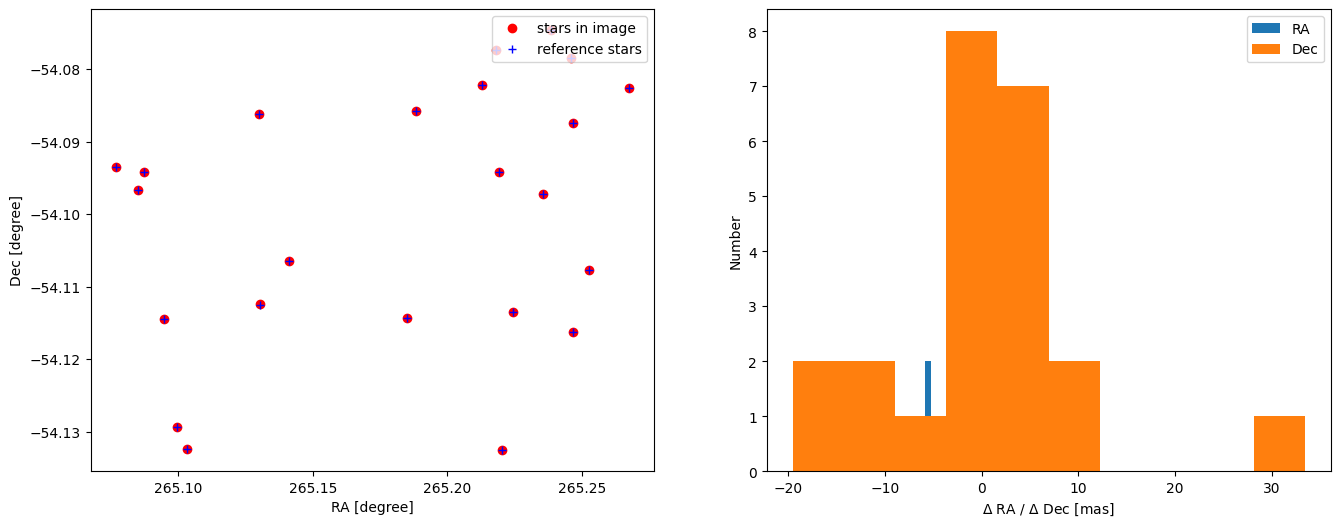

In [ ]:
# fig, axes = plt.subplots(1, 1, figsize= (6, 6))
# from matplotlib.ticker import MaxNLocator

# # axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
# axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
# axes.plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
# axes.set_ylabel("Dec [degree]")
# axes.set_xlabel("RA [degree]")
# axes.xaxis.set_major_locator(MaxNLocator(5))
# axes.legend(loc=1)
fig, axes = plt.subplots(1, 2, figsize= (16, 6))
from matplotlib.ticker import MaxNLocator
# axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

axes[0].plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
axes[0].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
axes[0].set_ylabel("Dec [degree]")
axes[0].set_xlabel("RA [degree]")
axes[0].xaxis.set_major_locator(MaxNLocator(5))
axes[0].legend(loc=1)


axes[1].hist((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000 * np.mean(np.cos(match_res_dec_gaia_uniqe / 180 * np.pi)), label="RA", bins=10, rwidth=0.3)
axes[1].hist((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000, label="Dec", bins=10, rwidth=1)
axes[1].set_xlabel(r"$\Delta$ RA / $\Delta$ Dec [mas]")
axes[1].set_ylabel("Number")
axes[1].legend(loc=1)

## 更新底片模型

### 全体星应用初步模型

In [ ]:
sext_flags = sext_out_filter[:]["FLAGS"]
sext_out_x = sext_out_filter[:]["X_IMAGE"][sext_flags == 0]
sext_out_y = sext_out_filter[:]["Y_IMAGE"][sext_flags == 0]

sext_out_xieta = function.use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD_PRE, cof_xy)
sext_out_radec = function.ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

sext_out_ra = sext_out_radec[0]
sext_out_dec = sext_out_radec[1]

### 全体星天球位置匹配

In [ ]:
refcat_lib_all = pd.DataFrame({"RA_ICRS": refcat_ra_now, "DE_ICRS": refcat_dec_now, "magrp": ref_filter["RPmag(mag)"], "magg": ref_filter["Gmag(mag)"], "magbp": ref_filter["BPmag(mag)"]})
side_threshold = 0.00001

match_res_all = []

for i in range(len(sext_out_ra)):
    temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
    index = np.sum(np.abs(refcat_lib_all.iloc[:, 0:2] - temp_lib) < side_threshold, axis=1) == 2
    if np.sum(index) == 1:
        match_res_all.append(np.hstack((np.array(temp_lib), int(i), refcat_lib_all.iloc[np.where(index == True)[0][0]])))

match_res_all = np.array(match_res_all)

### 计算更新的底片模型

In [ ]:
match_res_xi_gaia_all, match_res_eta_gaia_all = function.cel_ideal_coord(match_res_all[:, 3], match_res_all[:, 4], pointing_ra, pointing_dec)
Y_xi = match_res_xi_gaia_all
Y_eta = match_res_eta_gaia_all

match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)

for index, i in enumerate(match_res_all[:, 2]):
    match_res_x_sext_all[index] = sext_out_x[int(i)]
    match_res_y_sext_all[index] = sext_out_y[int(i)]

match_x = match_res_x_sext_all
match_y = match_res_y_sext_all
match_mag = match_res_all[:, band_index + 4]


print("the matched stars", len(match_x))

# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof_xy = 6
cof_mag = 3

A_CD = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)
print(A_CD)

the matched stars 656
[[-3.32149424e-06  2.42443502e-07 -8.70251489e-11  2.60587716e-14
   3.55600795e-13  9.27035578e-15 -1.35718943e-17 -9.84975952e-19
  -1.60701236e-17 -2.77955077e-19 -6.05471472e-23  1.65149010e-22
   4.36466046e-22  1.54300057e-22  2.91753753e-22  3.07799072e-27
   2.41833863e-26 -1.46637067e-26  2.01178342e-26 -6.37768951e-26
   4.07277253e-27  2.92128575e-30 -2.18431016e-30 -1.31453495e-29
  -4.63057163e-30 -4.94796297e-29 -5.04104633e-30 -1.78818329e-29
   4.37651558e-07 -2.11853078e-08  3.51612343e-10]
 [-3.94677981e-08  1.19645816e-10 -2.42589900e-07 -2.33082453e-13
  -2.17095351e-14 -6.49883136e-13 -1.04144808e-19  1.59626220e-17
  -6.34289295e-19  1.94795777e-17 -5.12195886e-23  1.46658213e-22
  -2.02820052e-23  3.63961941e-22  3.25631719e-22  5.02637860e-27
   8.29106620e-27  5.09598126e-26  7.37906187e-26  6.71662912e-26
  -2.88533970e-27  1.35769072e-30 -4.15662600e-30 -6.09229693e-30
  -2.40378589e-29 -3.11503796e-29 -1.77884286e-29 -1.95649312e-29
   

### 再应用更新的底片模型

In [ ]:
match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD, cof_xy, cof_mag)
match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)


# 残差
dis_xi = (match_xieta[0] - gaia_xieta[0])
dis_eta = (match_xieta[1] - gaia_xieta[1])
dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

print(np.std(dis_ra), np.std(dis_dec), cof_xy, cof_mag)

3.2105633865512013 1.349933248487009 6 3


In [ ]:
# 保存
cof_mag_orders = 4
cof_xy = 6
for cof_mag in np.arange(1, cof_mag_orders + 1):

    A_CD_LOOP = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)

    match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD_LOOP, cof_xy, cof_mag)
    match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
    gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
    gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)

    # 残差
    dis_xi = (match_xieta[0] - gaia_xieta[0])
    dis_eta = (match_xieta[1] - gaia_xieta[1])
    dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
    dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

    match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "DIS_XI": dis_xi, "DIS_ETA": dis_eta, "MAG": match_mag})

    with open(f'match_res/match_{band_short}_{unkonw_index}_{exp_time}_{cof_xy}_{cof_mag}.pkl', 'wb') as f:
        pickle.dump(match_res_pickle, f)

In [ ]:
# match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "DIS_XI": dis_xi, "DIS_ETA": dis_eta, "MAG": match_mag})

# with open(f'match_res/match_{band_short}_{unkonw_index}_{exp_time}.pkl', 'wb') as f:
#     pickle.dump(match_res_pickle, f)

# 残差分析

## 残差图

### 网格化

In [ ]:
# create bins
bins_num = 1
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_xi, dis_eta))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = function.cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# mag-distortion
bins_x_id, bins_y_id = function.match_box_id(match_x, match_y, bins_x, bins_y)

### 星等残差图

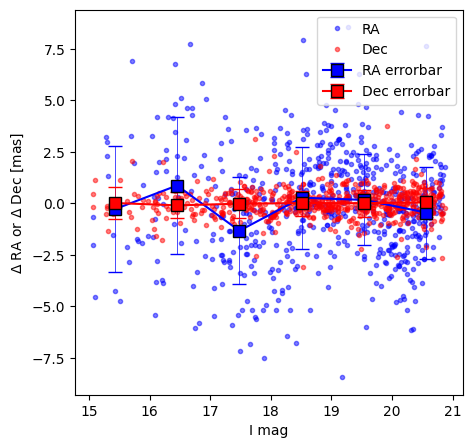

In [ ]:
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        index_box = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag[index_box]
        match_x_box = match_x[index_box]
        match_y_box = match_y[index_box]
        dis_ra_box = dis_ra[index_box]
        dis_dec_box = dis_dec[index_box]

        dis_ra_box, dis_dec_box, match_mag_box, filter = function.sigma_filter_2(dis_ra_box, dis_dec_box, match_mag_box, 3)
        index_mag = (match_mag_box < 29) & (match_mag_box > 15)

        dis_ra_box = dis_ra_box[index_mag]
        dis_dec_box = dis_dec_box[index_mag]
        match_mag_box = match_mag_box[index_mag]

        bin_centers_mag_box, bins_mean_dis_ra_box, bins_std_dis_ra_box = bins_divide(match_mag_box, dis_ra_box, 6)
        bin_centers_mag_box, bins_mean_dis_dec_box, bins_std_dis_dec_box = bins_divide(match_mag_box, dis_dec_box, 6)

        axe = axes if bins_num == 1 else axes[i][j]
        axe.plot(match_mag_box, dis_ra_box, '.', c='blue', label="RA", alpha = 0.5)
        axe.plot(match_mag_box, dis_dec_box, '.', c='red', label="Dec", alpha = 0.5)
        axe.errorbar(bin_centers_mag_box, bins_mean_dis_ra_box, yerr=bins_std_dis_ra_box, ecolor='blue',elinewidth=0.5,marker='s',mfc='blue',mec='k',mew=1,ms=8,alpha=1,capsize=5,capthick=3,color="blue",label="RA errorbar")
        axe.errorbar(bin_centers_mag_box, bins_mean_dis_dec_box, yerr=bins_std_dis_dec_box, ecolor='red',elinewidth=0.5,marker='s',mfc='red',mec='k',mew=1,ms=8,alpha=1,capsize=5,capthick=3,color="red",label="Dec errorbar")

        axe.set_xlabel(f"{band_short_capital} mag")
        axe.set_ylabel(r"$\Delta$ RA or $\Delta$ Dec [mas]")

        axe.legend()

### 位置残差图

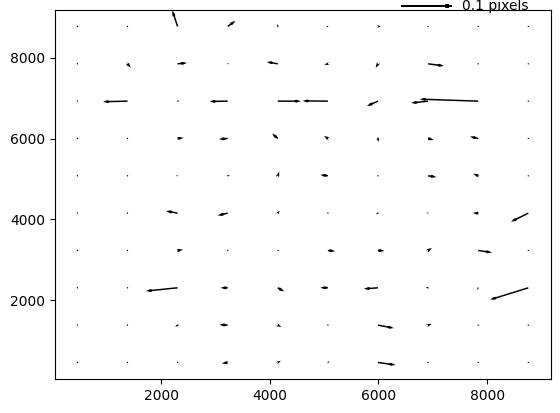

In [ ]:
bins_num = 10
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
dis_res_xy = [np.vstack((match_x[filter][index_mag], match_y[filter][index_mag], dis_ra[filter][index_mag], dis_dec[filter][index_mag]))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = function.cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

fig, axes = plt.subplots(1, 1)
quiver_scale = 9216
quiver_show_scale = 0.1
quiver = axes.quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten() / 50, distort_mean_values_y.flatten() / 50, scale=1 / quiver_scale, angles = 'xy', scale_units="xy", headwidth=2, headlength=3, width=0.003)
axes.quiverkey(quiver, 0.8, 1.01, quiver_show_scale, f"{quiver_show_scale} pixels",labelpos='E', coordinates='axes')